In [1]:
# by Joh Schöneberg 2018/2019

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#pathOfTheYeastTrackAnalysisFolder = '/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/'
pathOfTheYeastTrackAnalysisFolder = '/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/'

import sys
pythonPackagePath = pathOfTheYeastTrackAnalysisFolder+"/src/"
sys.path.append(pythonPackagePath)
import YeastTrackFunctions as ytf

# input data

In [22]:
#path = "/Users/yidi_lab/Desktop/YeastTrackAnalysis-master/dataToAnalyze/"
path = "/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/"

################
# THESE ARE THE ONLY PARAMETERS TO CHANGE

# change your filename to the file you want to analyze
#path_to_all_tracks_data = path+"end3/"
path_to_all_tracks_data = path+"sla1/"

allTracksFilename = 'all_tracks.csv'

goodTrajectoryIDsFilename = 'track_ids_to_be_analyzed.csv'

# 
frameToSecondConversion = 0.311
pixelToNanometerConversion = 65

excludeTheFirstNFrames = 6


align_intensity_threshold = 0.5 # 50% intensity alignment
showInflectionPointLines = True # toggle inflection point lines in the plot

minMaxRescaling_average_over_N_datapoints_for_new_zero_value = 1

################

outputpath = path_to_all_tracks_data

# Read the good trajectory IDs from a CSV (generated in step 1 or manually)

In [23]:
goodTrajecotryIDsFile = pd.read_csv(path+goodTrajectoryIDsFilename,header=None,names=['goodTrajectoryIDs'])
goodTrajectoryIDs = goodTrajecotryIDsFile['goodTrajectoryIDs'].values
goodTrajectoryIDs = np.sort(goodTrajectoryIDs)
print(goodTrajectoryIDs)

[ 16  42  57  59  67  69  73 126 142 170 172]


# read data

In [24]:
print(path+allTracksFilename)
alldata = pd.read_csv(path+allTracksFilename)

alldata[0:5]

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/all_tracks.csv


Trajectory  Frame          x        y  z       m0       m1       m2  \
0  1           1      0  178.64059  1.73866  0  1.01021  1.53177  3.14896   
1  2           1      1  178.60283  1.56601  0  1.14311  1.42251  2.64485   
2  3           1      2  179.00352  1.21462  0  1.27055  1.40107  2.48887   
3  4           1      3  179.21675  1.20335  0  1.14310  1.33682  2.22493   
4  5           1      4  179.17406  1.34643  0  1.29711  1.43147  2.76732   

        m3        m4  NPscore  
0  8.09806  25.60173  0.00420  
1  6.01314  16.99628  0.00244  
2  5.04188  11.40581  0.00249  
3  4.14449   8.52171  0.00250  
4  6.73493  20.44237  0.00260

# data processing

In [25]:
listOfOutputFilePaths = []

for trajectoryID in goodTrajectoryIDs:
    
    
    # get the data from a single trajectory
    data = alldata[alldata['Trajectory']==trajectoryID]
    data = data[excludeTheFirstNFrames:-1]
    data = data.reset_index(drop=True)


    # retrieve values
        
    x = data['x'].values
    y = data['y'].values
    intensity = data['m0']
    time = frameToSecondConversion*data['Frame']
    
    
    # calculate lifetime
    lifetime_frames = len(x)
    lifetime_seconds = np.round(frameToSecondConversion*lifetime_frames,decimals = 2)
    
    # calc distances from start

    distancesFromStart = []
    for i in range(1,len(data)):
        v0 = np.array([x[0],y[0]])
        v1 = np.array([x[i],y[i]])
        dist = np.linalg.norm(v0-v1)
        distancesFromStart.append(dist)
    distancesFromStart = pixelToNanometerConversion* np.array(distancesFromStart)
    distanceForExport = np.concatenate((np.array([0]),distancesFromStart))
    data['distance[nm]']=distanceForExport
    
    
    # speed
    frameByFrameDistances = []
    for i in range(1,len(data)):
        v0 = np.array([x[i-1],y[i-1]])
        v1 = np.array([x[i],y[i]])
        dist = np.linalg.norm(v0-v1)
        frameByFrameDistances.append(dist)
    frameByFrameDistances = np.array(frameByFrameDistances)
    data['speed[nm]'] = np.concatenate((np.array([0]),pixelToNanometerConversion*frameByFrameDistances))

    ##############    ##############    ##############    ##############    ##############
    
    # find inflection point from distances 
    
    x=np.arange(0,len(distancesFromStart))
    y=distancesFromStart
    inflectionPoint_fromDistance_Index = ytf.findInflectionPoint(x,y)
    inflectionPoint_fromDistance_Px = data['distance[nm]'][inflectionPoint_fromDistance_Index]
    inflectionPoint_fromDistance_Frame = data['Frame'][inflectionPoint_fromDistance_Index]
    inflectionPoint_fromDistance_Time = frameToSecondConversion*(data['Frame'][inflectionPoint_fromDistance_Index])
    inflectionPoint_fromDistance_Intensity = data['m0'][inflectionPoint_fromDistance_Index]
    

    # find inflection point from intensity RAW
    intensity = data['m0']
    max_intensity_AU  = np.round(np.max(intensity),decimals=2)
    inflectionPoint_fromIntensity_raw_AU = align_intensity_threshold*max_intensity_AU
    inflectionPoint_fromIntensity_raw_index = np.where(intensity>inflectionPoint_fromIntensity_raw_AU)[0][0]
    inflectionPoint_fromIntensity_raw_Frame = data['Frame'][inflectionPoint_fromIntensity_raw_index]
    inflectionPoint_fromIntensity_raw_Time = frameToSecondConversion*(data['Frame'][inflectionPoint_fromIntensity_raw_index])
    inflectionPoint_fromIntensity_raw_Intensity = data['m0'][inflectionPoint_fromIntensity_raw_index]
    
    # find inflection point from intensity MinMaxRescaled
    intensity = data['m0']
    max_intensity_AU  = np.round(np.max(intensity),decimals=2)
    #as a min intensity, take the mean of the first N datapoints
    start_intensity_AU = np.round(np.average(intensity[0:minMaxRescaling_average_over_N_datapoints_for_new_zero_value]))
    inflectionPoint_fromIntensity_minMaxRescaled_AU = align_intensity_threshold*(max_intensity_AU-start_intensity_AU)
    inflectionPoint_fromIntensity_minMaxRescaled_index = np.where((intensity-start_intensity_AU)>inflectionPoint_fromIntensity_minMaxRescaled_AU)[0][0]
    inflectionPoint_fromIntensity_minMaxRescaled_Frame = data['Frame'][inflectionPoint_fromIntensity_minMaxRescaled_index]
    inflectionPoint_fromIntensity_minMaxRescaled_Time = frameToSecondConversion*(data['Frame'][inflectionPoint_fromIntensity_minMaxRescaled_index])
    inflectionPoint_fromIntensity_minMaxRescaled_Intensity = data['m0'][inflectionPoint_fromIntensity_minMaxRescaled_index]
   
    ##############    ##############    ##############    ##############    ##############
    # export as excels
    data['time[s]']=time
    data['lifetime_frames'] = lifetime_frames
    data['lifetime_seconds'] = lifetime_seconds
    data['max_intensity_AU'] = np.round(np.max(intensity),decimals=2)
    normDistanceForExport = np.concatenate((np.array([0]),(distancesFromStart-np.min(distancesFromStart))/np.max(distancesFromStart-np.min(distancesFromStart))))
    data['distance normalized']= normDistanceForExport
    
    #inflection point by distance
    data['inflectionPoint_fromDistance_AU']=inflectionPoint_fromDistance_Px
    data['inflectionPoint_fromDistance_Index']=inflectionPoint_fromDistance_Index
    data['inflectionPoint_fromDistance_Frame']=inflectionPoint_fromDistance_Frame
    data['inflectionPoint_fromDistance_Time']=inflectionPoint_fromDistance_Time
    data['inflectionPoint_fromDistance_Intensity']=inflectionPoint_fromDistance_Intensity
    data['time_aligned_by_inflectionPoint_fromDistance[s]']=time-inflectionPoint_fromDistance_Time

    
    #inflection point by intensity RAW
    data['inflectionPoint_fromIntensity_alignment_threshold'] = align_intensity_threshold # e.g. 0.5 = 50%
    data['inflectionPoint_fromIntensity_raw_AU'] = inflectionPoint_fromIntensity_raw_AU
    data['inflectionPoint_fromIntensity_raw_Index']=inflectionPoint_fromIntensity_raw_index
    data['inflectionPoint_fromIntensity_raw_Frame']=inflectionPoint_fromIntensity_raw_Frame
    data['inflectionPoint_fromIntensity_raw_Time']=inflectionPoint_fromIntensity_raw_Time
    data['inflectionPoint_fromIntensity_raw_Intensity']=inflectionPoint_fromIntensity_raw_Intensity
    data['time_aligned_by_inflectionPoint_fromIntensity_raw[s]']=time-inflectionPoint_fromIntensity_raw_Time
    
    #inflection point by intensity minMaxRescaled
    data['inflectionPoint_fromIntensity_minMaxRescaled_AU'] = inflectionPoint_fromIntensity_minMaxRescaled_AU
    data['inflectionPoint_fromIntensity_minMaxRescaled_Index']=inflectionPoint_fromIntensity_minMaxRescaled_index
    data['inflectionPoint_fromIntensity_minMaxRescaled_Frame']=inflectionPoint_fromIntensity_minMaxRescaled_Frame
    data['inflectionPoint_fromIntensity_minMaxRescaled_Time']=inflectionPoint_fromIntensity_minMaxRescaled_Time
    data['inflectionPoint_fromIntensity_minMaxRescaled_Intensity']=inflectionPoint_fromIntensity_minMaxRescaled_Intensity
    data['time_aligned_by_inflectionPoint_fromIntensity_raw[s]']=time-inflectionPoint_fromIntensity_minMaxRescaled_Time



    outputFilePath = outputpath+allTracksFilename+'_'+str(trajectoryID)+'_processed.csv'
    print(outputFilePath)
    listOfOutputFilePaths.append(outputFilePath)
    data.to_csv(outputFilePath)
    
processedDataFilePath = outputpath+allTracksFilename+'_allProcessedFilePaths.csv'
print(processedDataFilePath)
df = pd.DataFrame()
df['filenames'] = listOfOutputFilePaths
df.to_csv(processedDataFilePath)


/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_16_processed.csv
/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_42_processed.csv
/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_57_processed.csv
/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_59_processed.csv
/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_67_processed.csv
/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_69_processed.csv
/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_73_processed.csv
/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample

# plotting

In [26]:
def plotOverview(outputFilePath):
    

    
    ################
    # gather the data for plotting
    ################
    
    data = pd.read_csv(outputFilePath)
    x = data['x'].values
    y = data['y'].values
    intensity = data['m0']
    distance = data['distance[nm]']
    speed = data['speed[nm]']
    time = data['time[s]']
    
    # single point data
    inflectionPoint_fromDistance_Index = data['inflectionPoint_fromDistance_Index'][0]
    inflectionPoint_fromIntensity_raw_Index = data['inflectionPoint_fromIntensity_raw_Index'][0]
    inflectionPoint_fromIntensity_minMaxRescaled_Index = data['inflectionPoint_fromIntensity_minMaxRescaled_Index'][0]

    inflectionPointFrame = data['inflectionPoint_fromDistance_Frame'][0]
    inflectionPointTime = data['inflectionPoint_fromDistance_Time'][0]
    inflectionPointIntensity = data['inflectionPoint_fromDistance_Intensity'][0]
    max_intensity_AU = data['max_intensity_AU'][0]
    lifetime_frames = data['lifetime_frames'][0]
    lifetime_seconds = data['lifetime_seconds'][0]
    trackId = data['Trajectory'][0]

    
    
    ################
    # setup the plot
    ################
    ncols =5.
    fig = plt.figure(figsize=plt.figaspect(1/(ncols)),dpi=300)


    
    ################
    # 1st subplot
    ################
    ax = fig.add_subplot(1, ncols, 1)
    
    ax.plot(x,y,lw=3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal', adjustable='box')
    
    
    
        
    ################
    # 1.5st subplot
    ################
    ax = fig.add_subplot(1, ncols, 2)
    
    ax.plot(time,intensity,lw=3)
    ax.set_xlabel('time[s]')
    ax.set_ylabel('intensity[AU]')
    ax.set_aspect('auto', adjustable='box')
    plt.axvline(time[0:-1][inflectionPoint_fromIntensity_raw_Index],c='red')
    plt.axvline(time[0:-1][inflectionPoint_fromIntensity_minMaxRescaled_Index],c='blue')

    
        
    #################
    # 2nd subplot
    #################
    ax = fig.add_subplot(1, ncols, 3)
    
    ax.plot(time,distance,lw=3)
    ax.set_xlabel('time[s]')
    ax.set_ylabel('distance[nm]')
    plt.axvline(time[0:-1][inflectionPoint_fromDistance_Index],c='k')
    
    
    #################
    # 3rd subplot
    #################
    ax = fig.add_subplot(1, ncols, 4)
    

    plt.plot(time,speed,lw=3)
    ax.set_xlabel('time[s]')
    ax.set_ylabel('speed[nm]')
    
    
    ################
    # 4th subplot
    ################
    ax = fig.add_subplot(1, ncols, 5)
    ax.set_title('_')
    
    
    plt.plot(time,(distance-np.min(distance))/np.max(distance-np.min(distance)),lw=3)
    plt.plot(time,(intensity-np.min(intensity))/np.max(intensity-np.min(intensity)),lw=3)
    
    plt.xlabel('time [s]')
    plt.ylabel('dist [nm] \ intensity [AU]')
    
    
    if(showInflectionPointLines):
        plt.axvline(time[0:-1][inflectionPoint_fromDistance_Index],c='k')
        plt.axvline(time[0:-1][inflectionPoint_fromIntensity_raw_Index],c='red')
        plt.axvline(time[0:-1][inflectionPoint_fromIntensity_minMaxRescaled_Index],c='blue')
    

    
    plt.suptitle("TrackID: {}, Lifetime: {}frames = {}s, MaxInt: {}AU align, dist:black, intensityRaw:red, intensityRescaled:blue\n \n".format(trackId,lifetime_frames,lifetime_seconds,max_intensity_AU))
    
    plt.tight_layout ()
    
    
    outputFigurePath= outputFilePath+".png"
    print(outputFigurePath)
    plt.savefig(outputFigurePath)
    plt.show()
    

    
    plt.close()

# Plot all the tracks in the folder

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_16_processed.csv.png


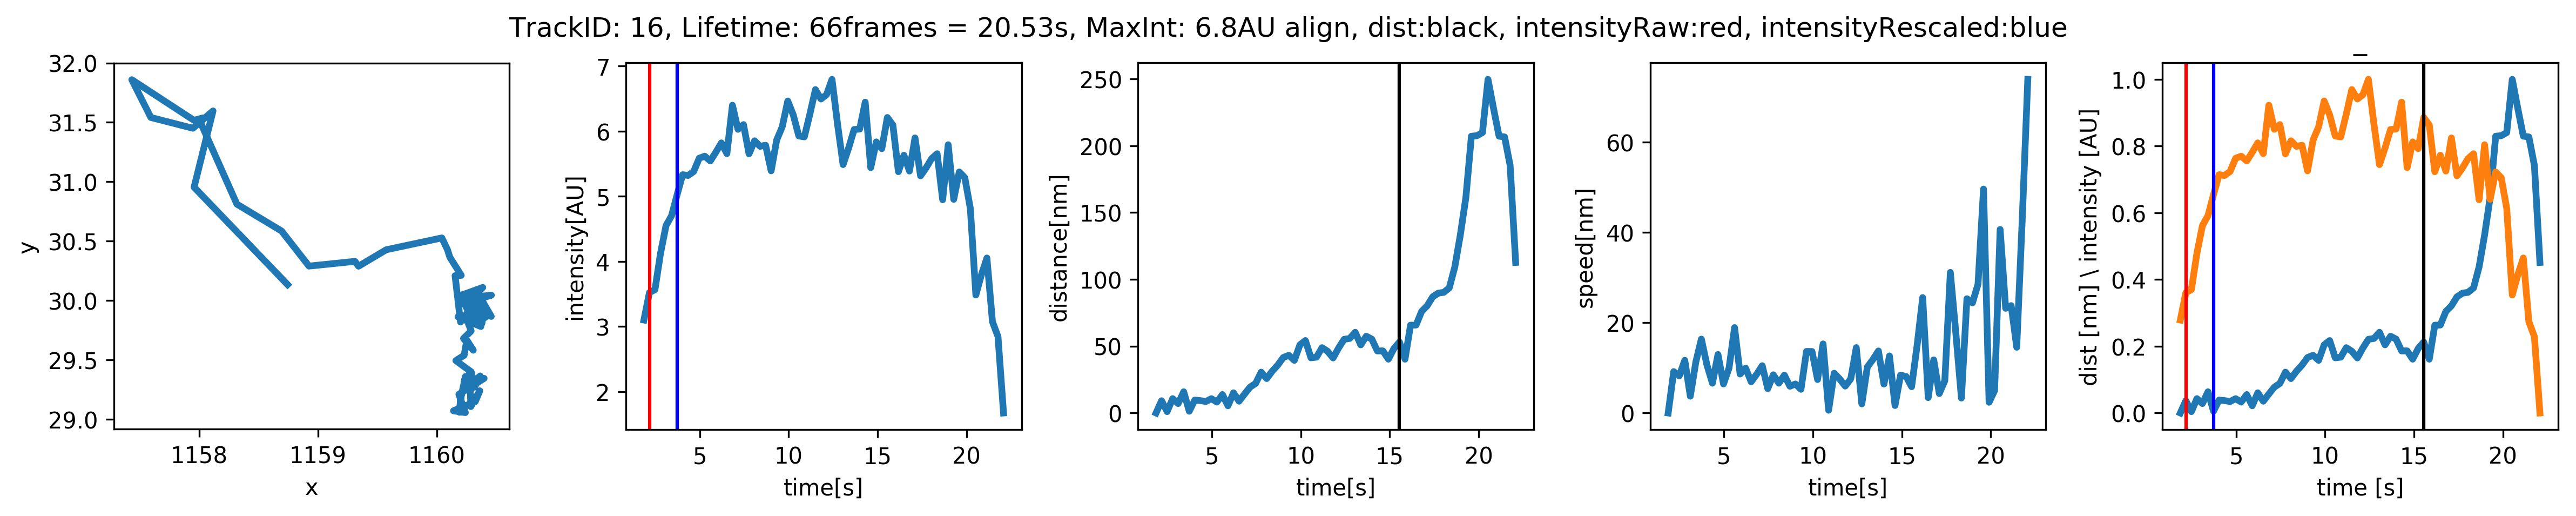

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_42_processed.csv.png


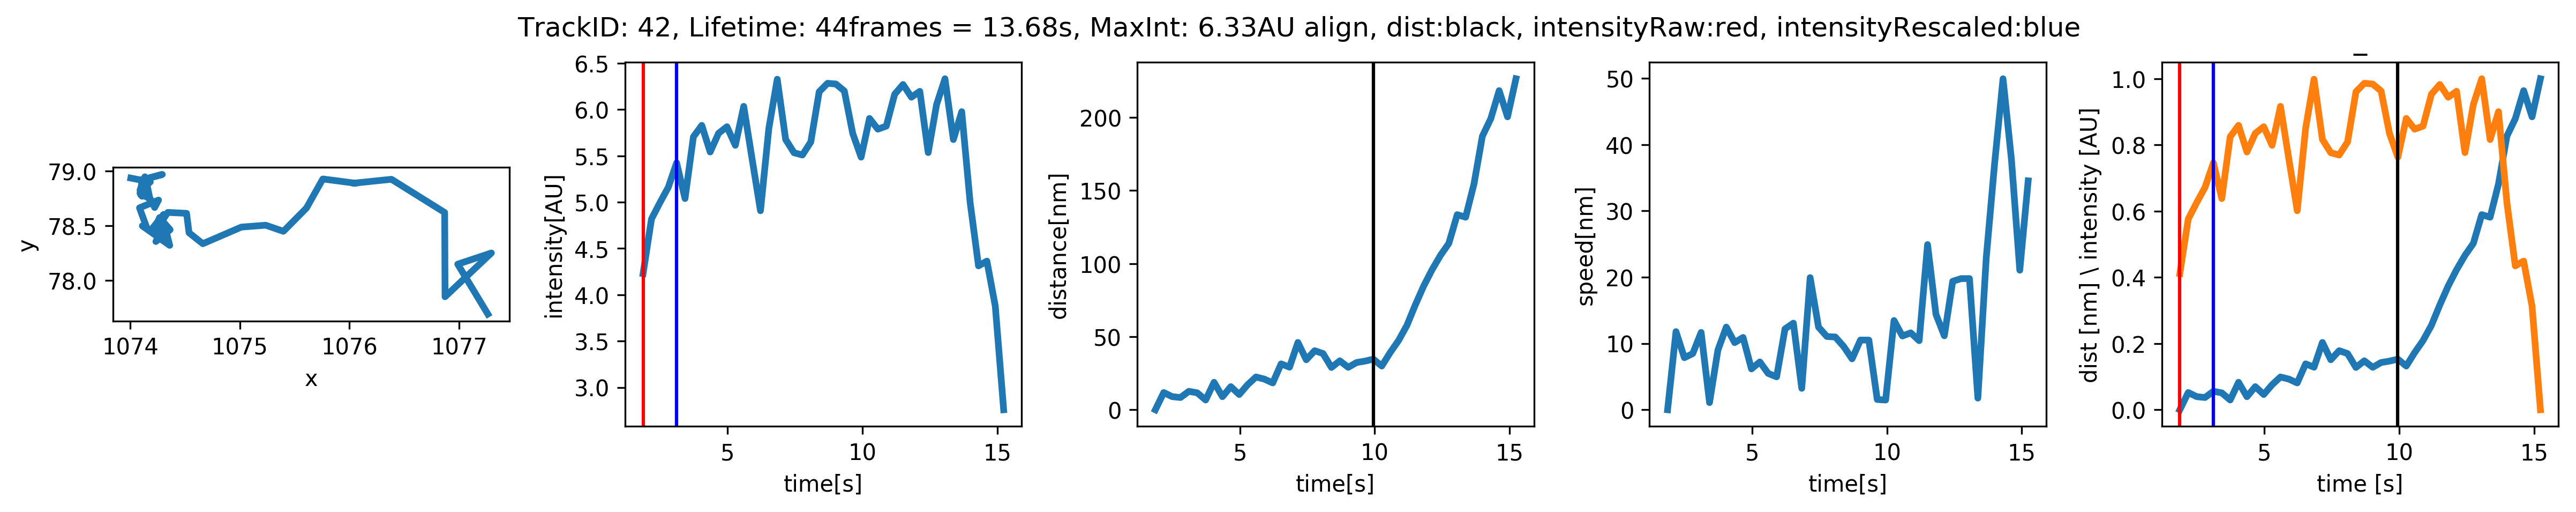

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_57_processed.csv.png


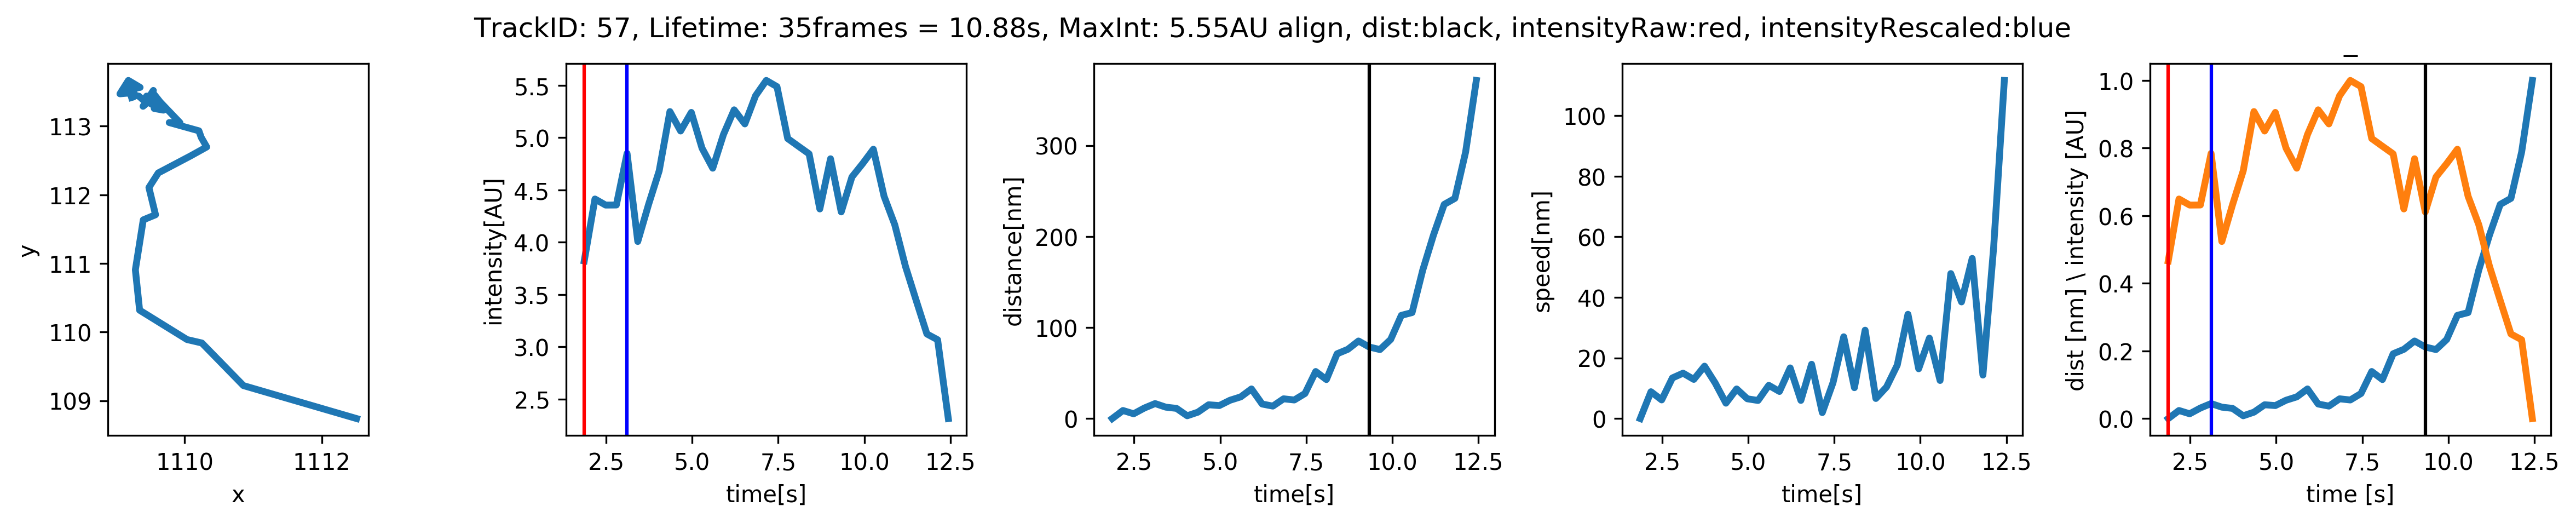

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_59_processed.csv.png


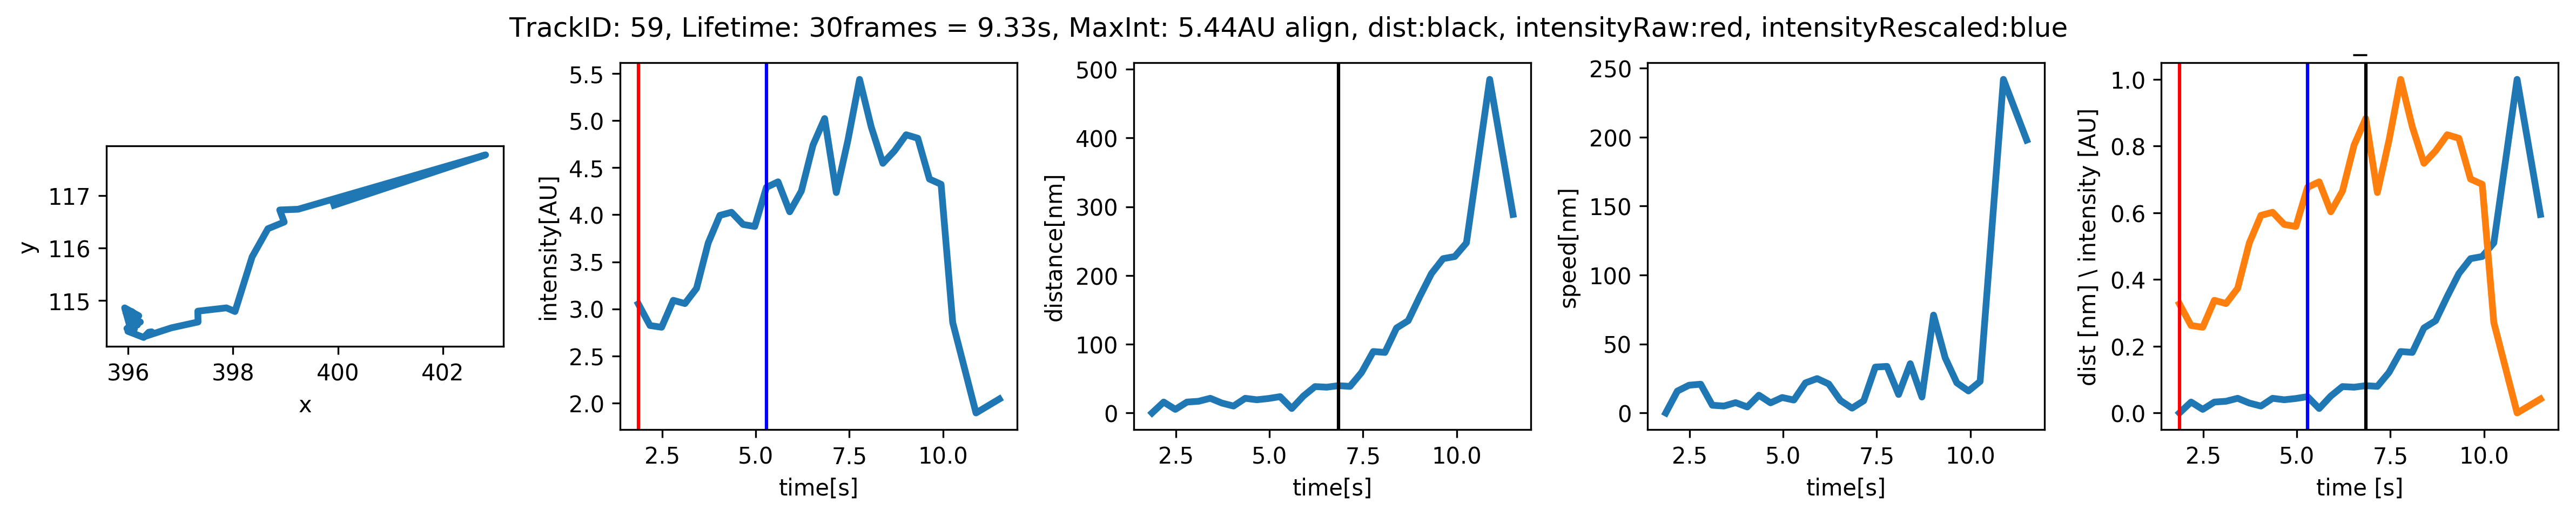

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_67_processed.csv.png


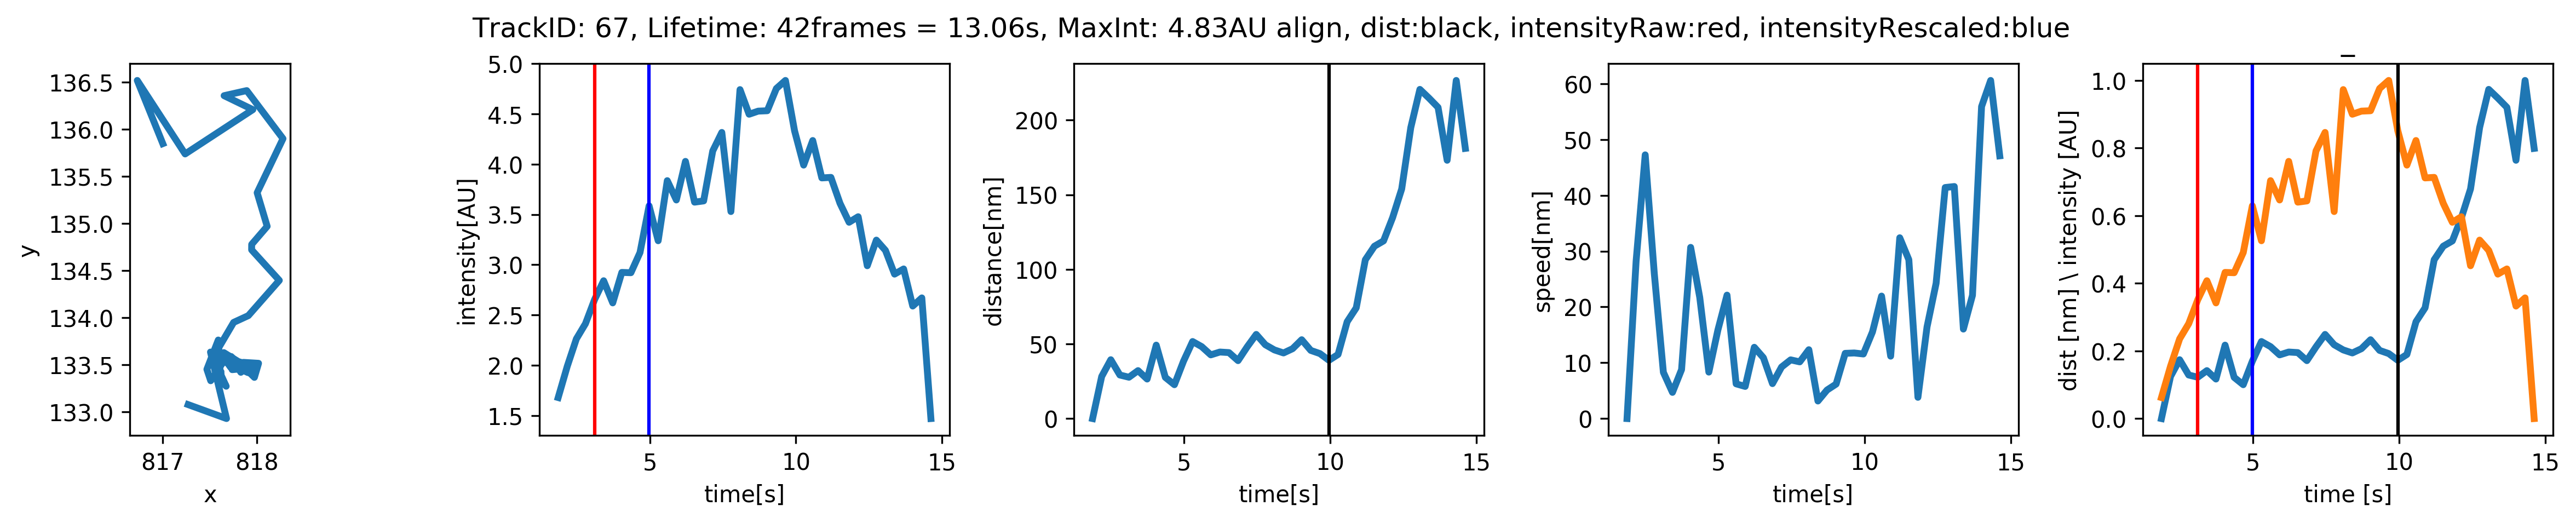

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_69_processed.csv.png


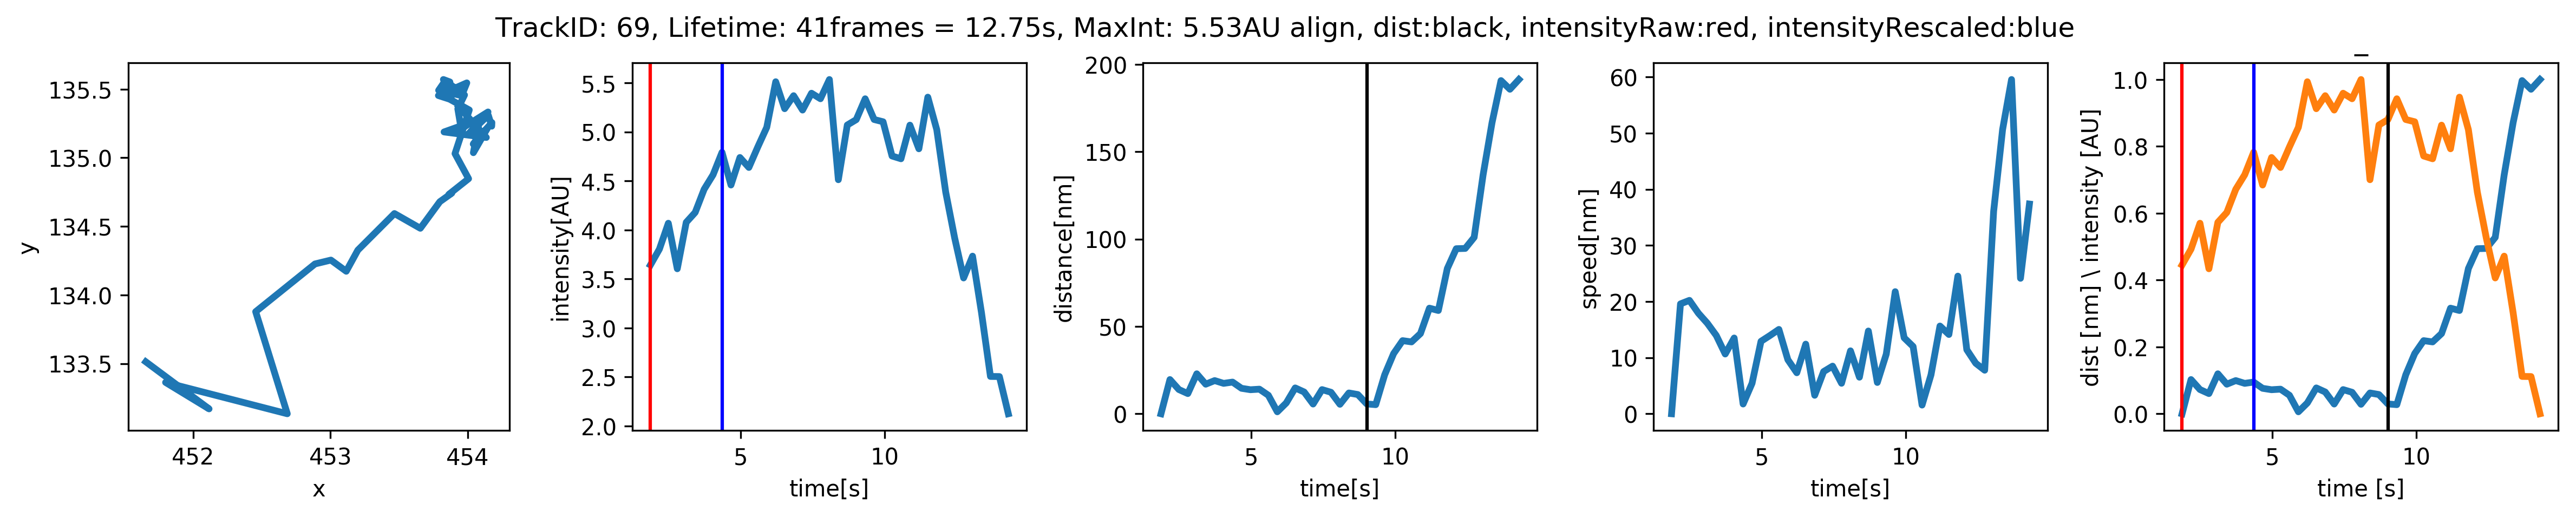

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_73_processed.csv.png


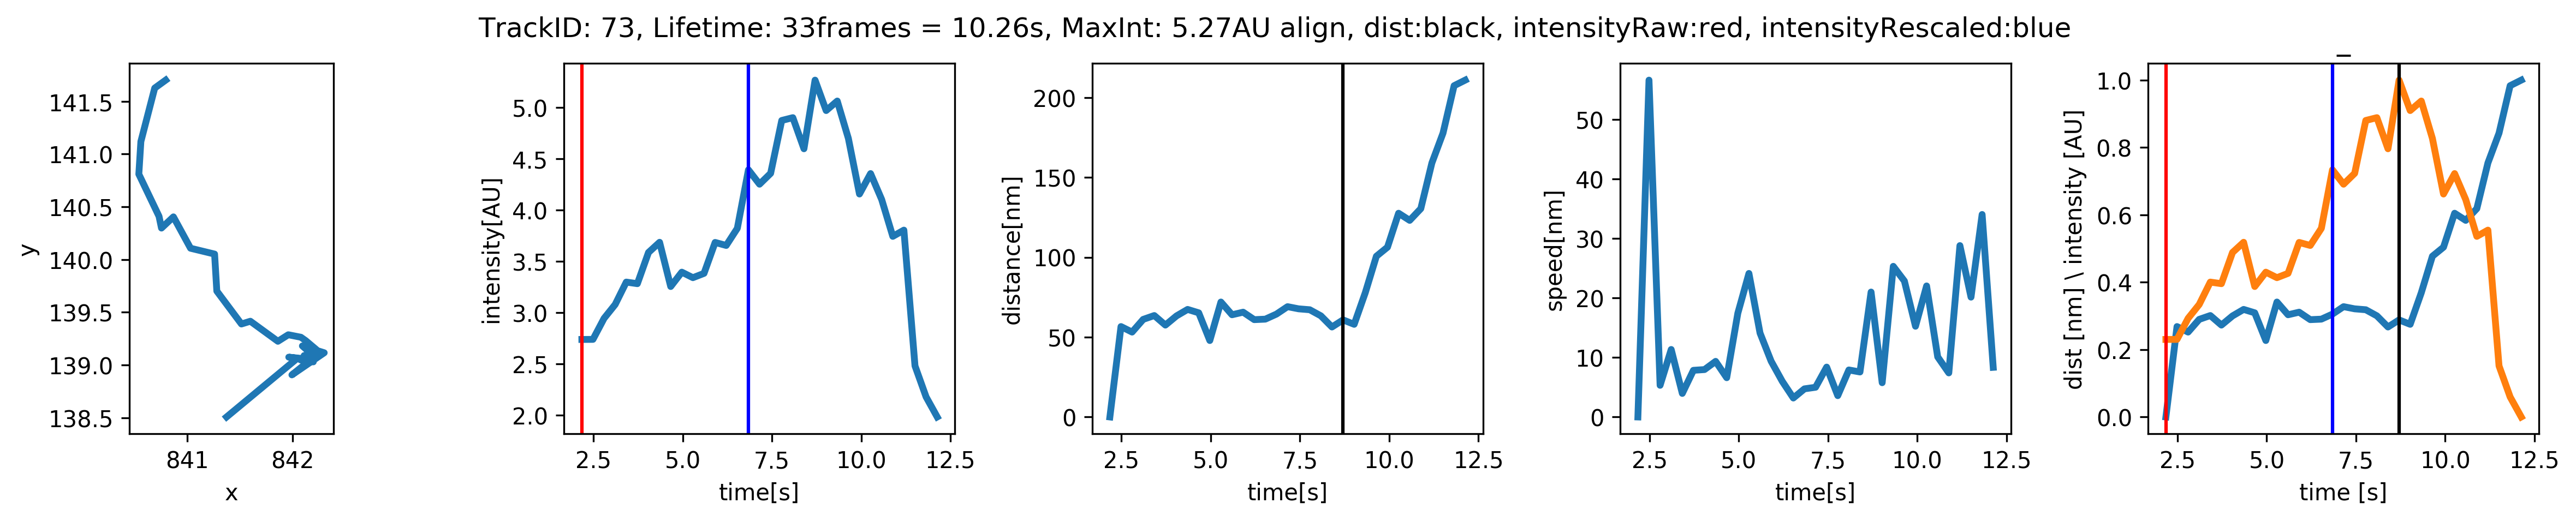

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_126_processed.csv.png


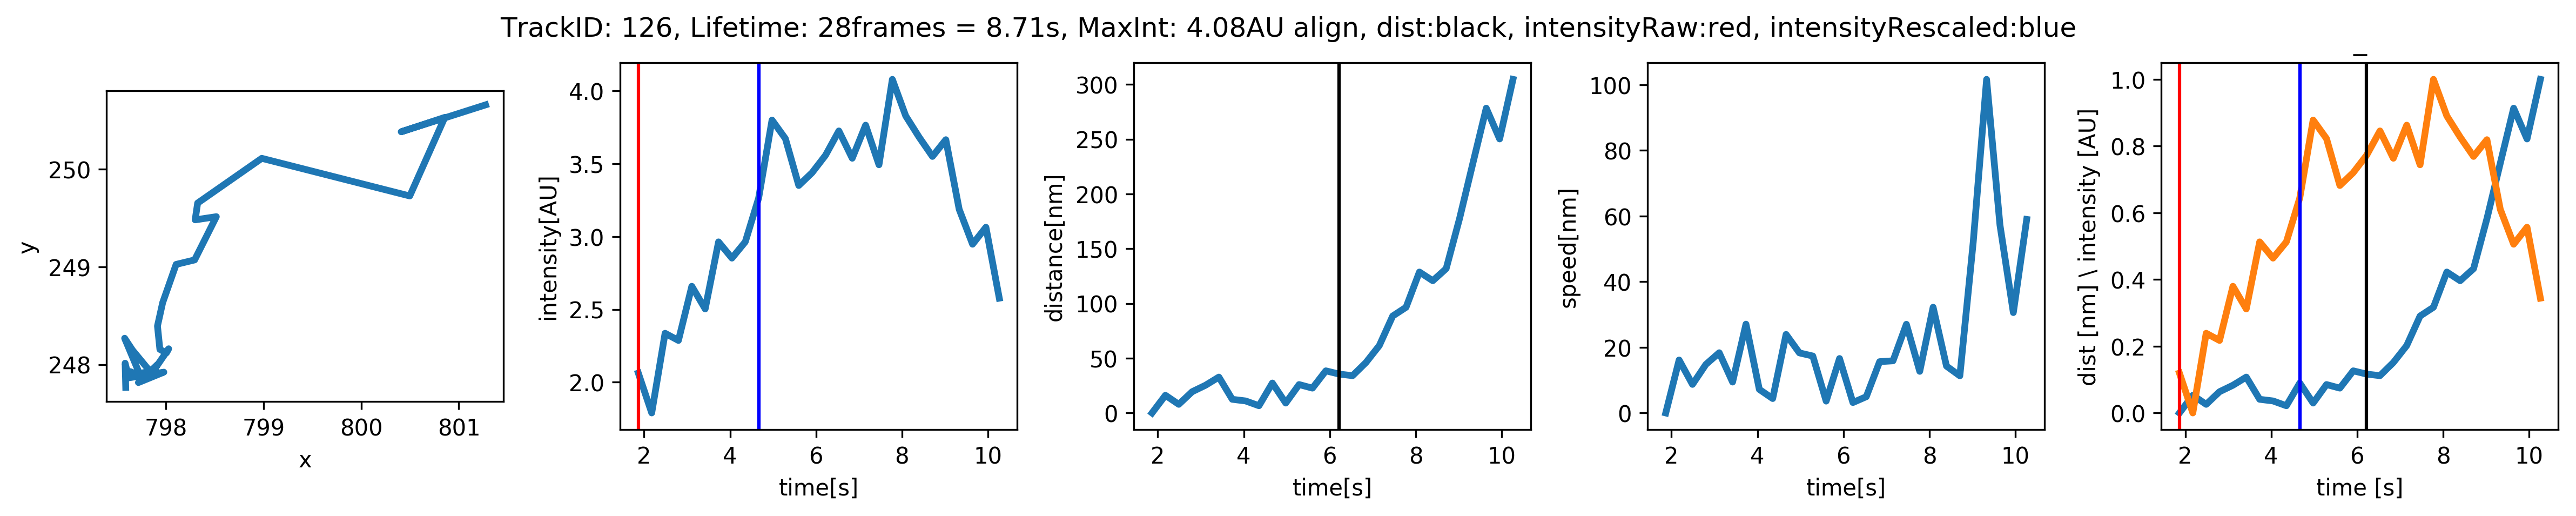

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_142_processed.csv.png


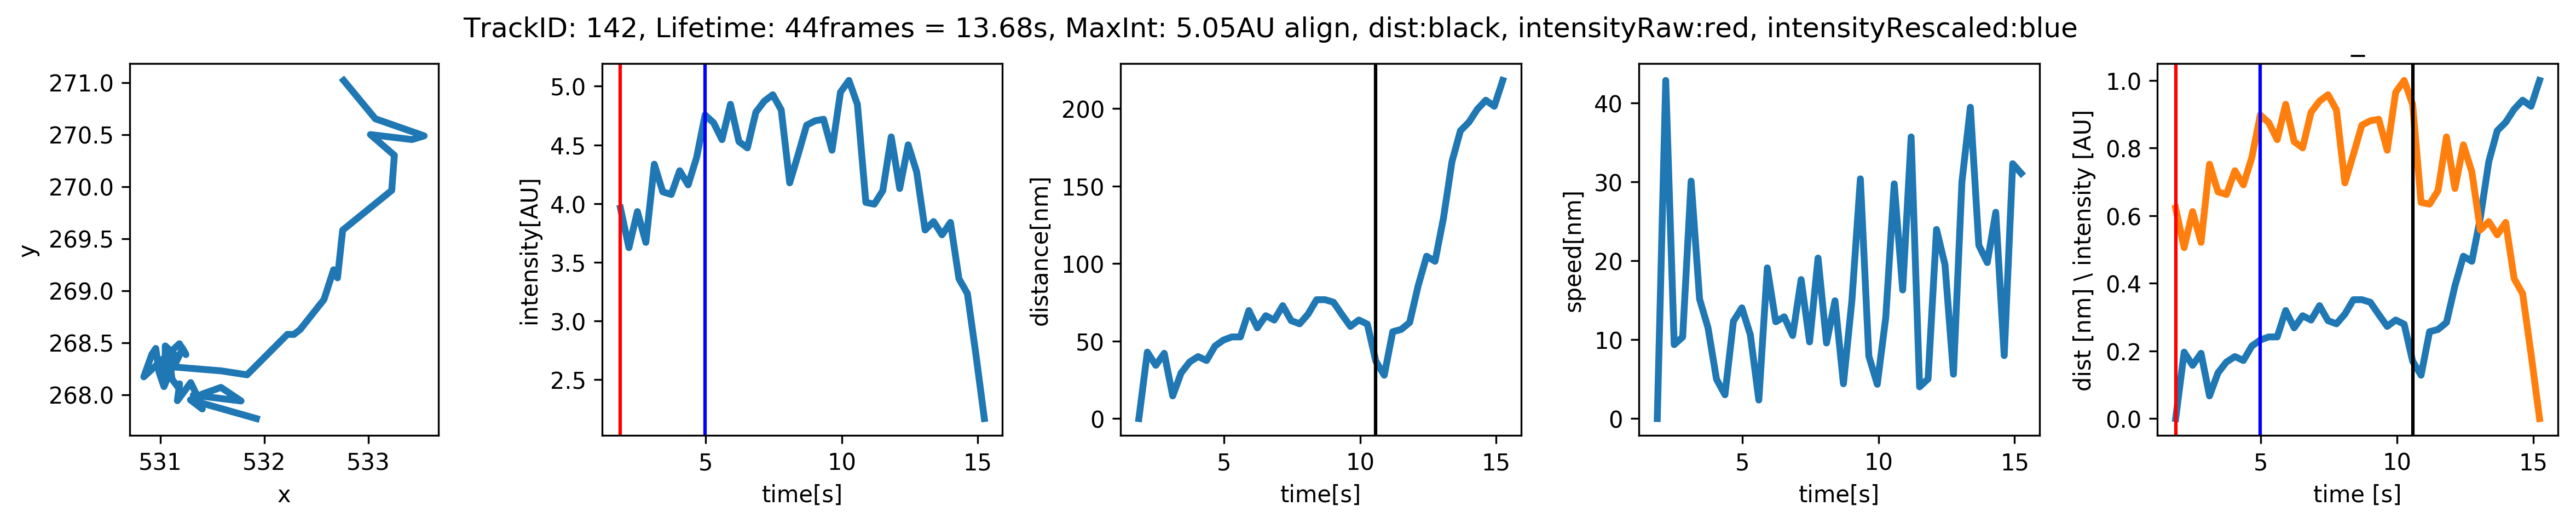

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_170_processed.csv.png


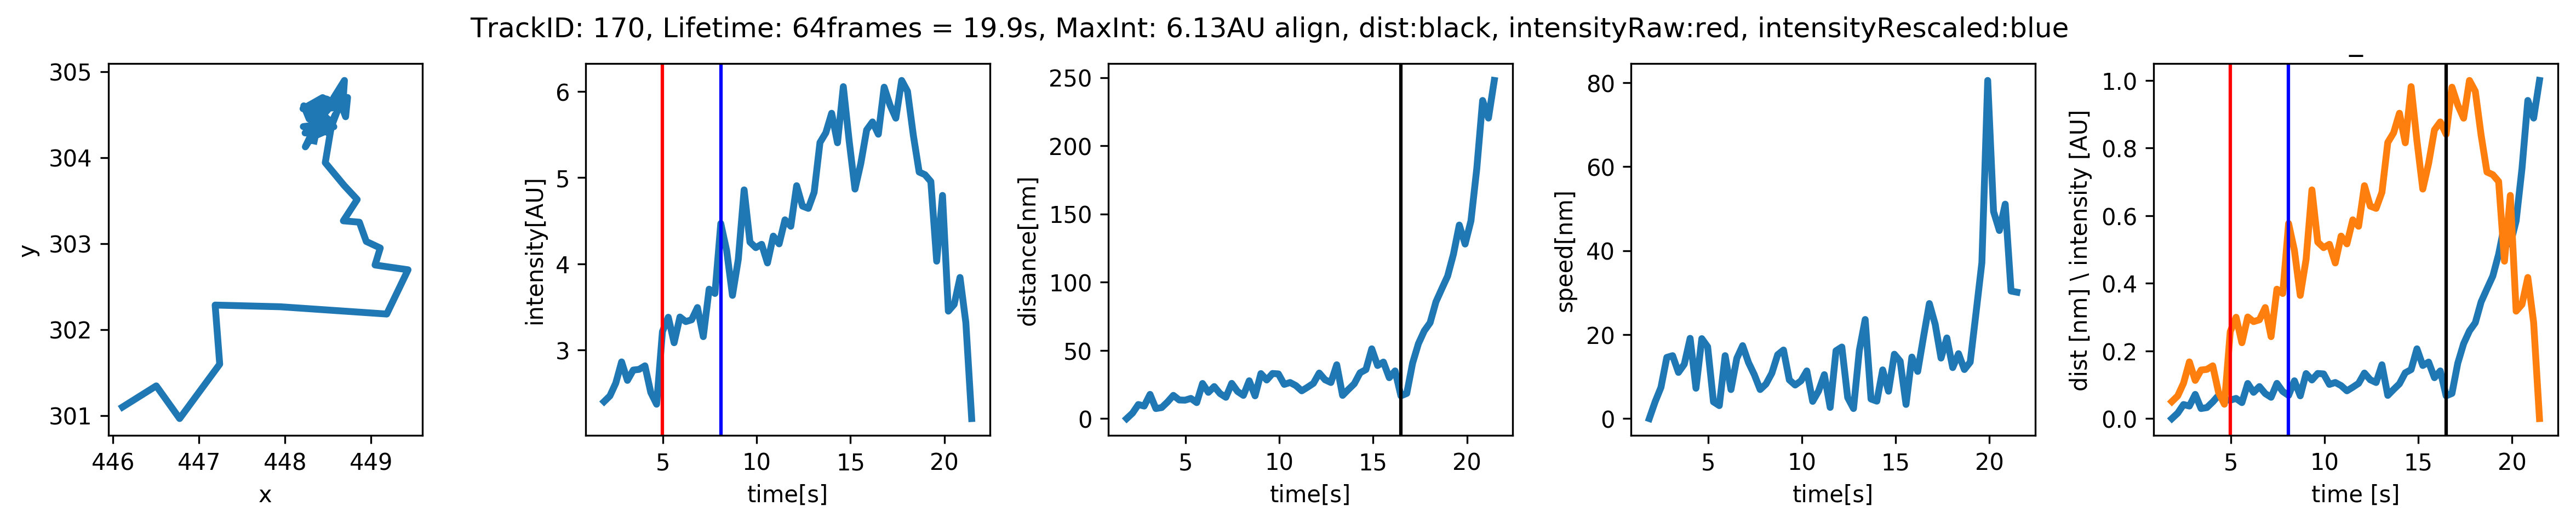

/Users/johannesschoeneberg/git/DrubinBarnes/YeastTrackAnalysis/sample_data_goodFromExcel/forJoh/sla1/all_tracks.csv_172_processed.csv.png


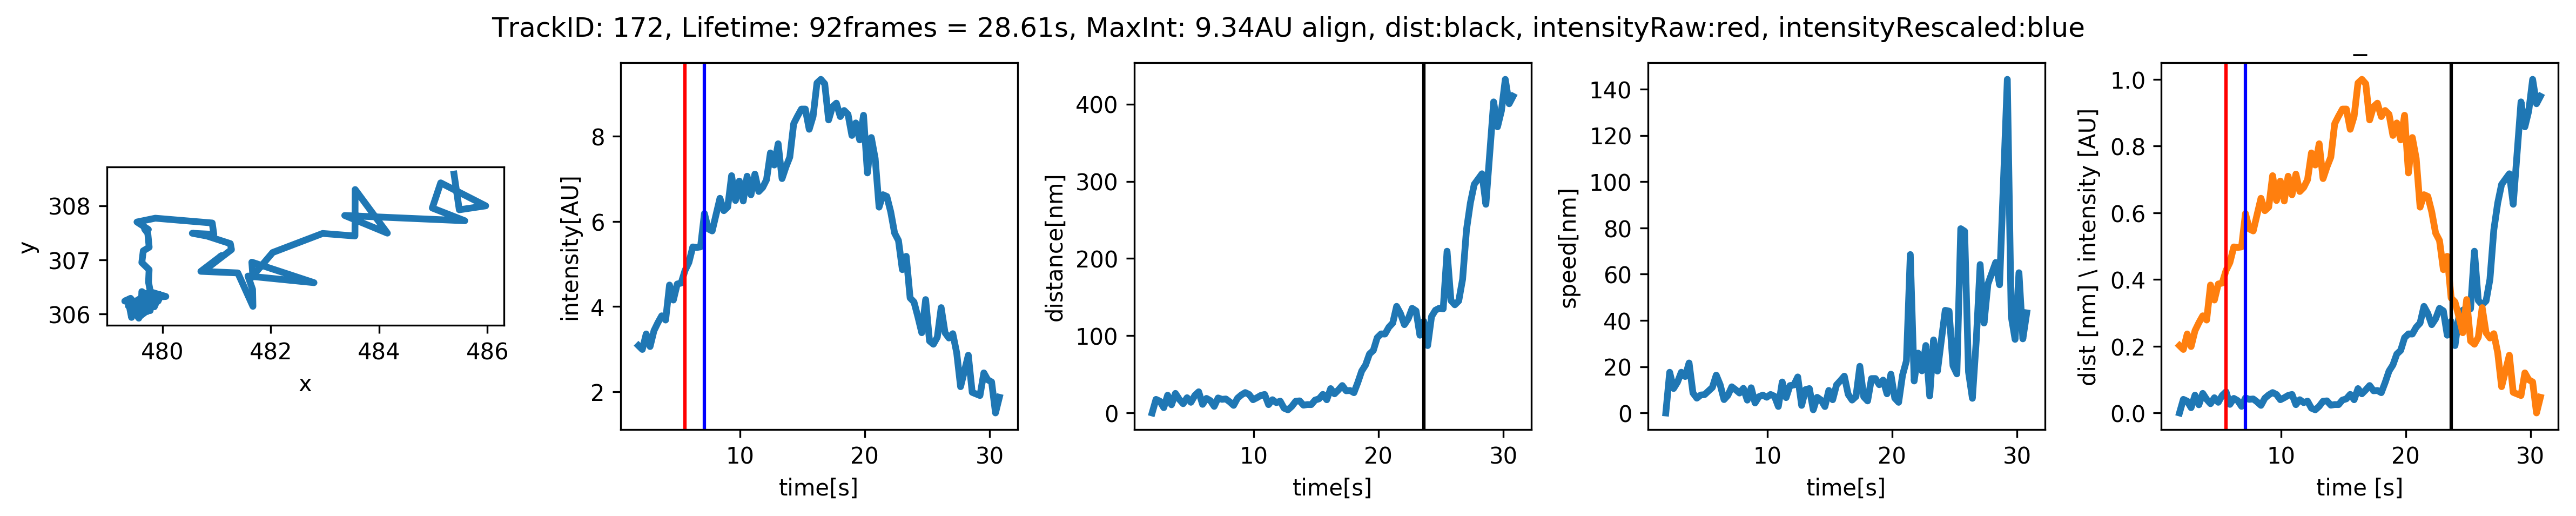

In [27]:
for outputFilePath in listOfOutputFilePaths:
    plotOverview(outputFilePath)

# just in case: For plotting one individual one by filepath

In [9]:
#plotOverview("/Users/sun.hong/Desktop/YeastTrackAnalysis-master/dataToAnalyze/fission yeast fim1-gfp/all_tracks.csv_236_processed.csv")